# 加载数据

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv(
    "../datasets/ner/kaggle-entity-annotated-corpus/ner_dataset.csv",
    encoding="latin1").fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [2]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        
        # 按句子分组
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(
            s["Word"].values.tolist(), s["POS"].values.tolist(), s["Tag"].
            values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [9]:
getter = SentenceGetter(data)

In [14]:
# 数据以句子为单位，每个句子由 单词-词性-实体类别 三元组组成
getter.grouped.head(5)

Sentence #
Sentence: 1        [(Thousands, NNS, O), (of, IN, O), (demonstrat...
Sentence: 10       [(Iranian, JJ, B-gpe), (officials, NNS, O), (s...
Sentence: 100      [(Helicopter, NN, O), (gunships, NNS, O), (Sat...
Sentence: 1000     [(They, PRP, O), (left, VBD, O), (after, IN, O...
Sentence: 10000    [(U.N., NNP, B-geo), (relief, NN, O), (coordin...
dtype: object

In [15]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
print(sentences[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']


In [16]:
labels = [[s[2] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [17]:
# 创建标签字典

tag_values = list(set(data["Tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [18]:
print(tag2idx)

{'I-art': 0, 'I-nat': 1, 'B-org': 2, 'I-org': 3, 'B-tim': 4, 'B-art': 5, 'I-eve': 6, 'B-geo': 7, 'O': 8, 'B-nat': 9, 'B-eve': 10, 'B-gpe': 11, 'I-gpe': 12, 'I-per': 13, 'B-per': 14, 'I-tim': 15, 'I-geo': 16, 'PAD': 17}


> 添加了 `PAD` 标签

# 数据管道

In [19]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.4.0'

In [20]:
# 参数
MAX_LEN = 75
bs = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [21]:
device

device(type='cuda')

In [22]:
n_gpu

1

In [23]:
torch.cuda.get_device_name(0)

'GeForce RTX 2080 Ti'

In [24]:
# 分词器

model_path = "../../H/models/huggingface/torch/bert-base-cased/"
tokenizer = BertTokenizer.from_pretrained(model_path, do_lower_case=False)

In [25]:
# 单词可能拆分成子词

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [26]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [27]:
tokenized_texts = [
    token_label_pair[0] for token_label_pair in tokenized_texts_and_labels
]
labels = [
    token_label_pair[1] for token_label_pair in tokenized_texts_and_labels
]

In [28]:
print(tokenized_texts[10])

['In', 'Beirut', ',', 'a', 'string', 'of', 'officials', 'voiced', 'their', 'anger', ',', 'while', 'at', 'the', 'United', 'Nations', 'summit', 'in', 'New', 'York', ',', 'Prime', 'Minister', 'F', '##ou', '##ad', 'Sin', '##ior', '##a', 'said', 'the', 'Lebanese', 'people', 'are', 're', '##sol', '##ute', 'in', 'preventing', 'such', 'attempts', 'from', 'destroying', 'their', 'spirit', '.']


In [29]:
print(labels[10])

['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-org', 'I-org', 'O', 'O', 'B-geo', 'I-geo', 'O', 'B-per', 'O', 'B-per', 'B-per', 'B-per', 'I-per', 'I-per', 'I-per', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [30]:
# 文本转换成数值向量，并处理成等长

input_ids = pad_sequences(
    [tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
    maxlen=MAX_LEN,
    dtype="long",  # np.int64。满足 torch 中的模块的要求
    value=0.0,
    truncating="post",
    padding="post",
)

In [32]:
# 标签转换成数值向量，并处理成等长

tags = pad_sequences(
    [[tag2idx.get(l) for l in lab] for lab in labels],
    maxlen=MAX_LEN,
    value=tag2idx["PAD"],
    padding="post",
    dtype="long",
    truncating="post",
)

In [36]:
# 输入掩码，表征哪些元素是填充的

attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]
# attention_masks = input_ids != 0

In [37]:
# 拆分数据集，训练、验证、测试

tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(
    input_ids,
    tags,
    random_state=2018,
    test_size=0.1,
)
tr_masks, val_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=2018,
    test_size=0.1,
)

In [38]:
# 转换成 torch 张量

tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [39]:
# 创建批量数据集

train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

# 创建模型

In [40]:
import transformers
from transformers import BertForTokenClassification, AdamW

transformers.__version__

'2.10.0'

In [41]:
# Bert 用于分类
model = BertForTokenClassification.from_pretrained(
    model_path,
    num_labels=len(tag2idx),  # 分类类别数，加上了 PAD
    output_attentions=False,
    output_hidden_states=False,
)

In [42]:
model.cuda();

In [44]:
# 1. 优调整个模型，bert 模型及其上的分类层

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [{
        'params':
        [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.01
    }, {
        'params':
        [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
        'weight_decay_rate':
        0.0
    }]

# 2. 仅仅训练最顶层的分类层    
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{
        "params": [p for n, p in param_optimizer]
    }]

# 优化器    
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5, eps=1e-8)

In [45]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# 总的训练次数
total_steps = len(train_dataloader) * epochs

# 学习率规划
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps,
)

# 训练模型

In [47]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

In [61]:
## 记录每一周次训练完的平均损失和验证损失
loss_values, validation_loss_values = [], []

for epoch in trange(epochs, desc="Epoch"):
    # ========================================
    #               训练
    # ========================================

    #  训练模式
    model.train()

    # 损失
    total_loss = 0

    # 训练循环
    for step, batch in enumerate(train_dataloader):
        # 数据 gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # 梯度清零
        model.zero_grad()

        # 前向计算，获得损失
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs[0]

        # 反向传播
        loss.backward()

        # 累加损失
        total_loss += loss.item()

        # 梯度裁剪，防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(),
                                       max_norm=max_grad_norm)
        # 更新参数
        optimizer.step()
        # 更新学习率
        scheduler.step()

    # 计算每一训练循环的平均损失
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {} at epoch {}".format(avg_train_loss, epoch))

    loss_values.append(avg_train_loss)

    # ========================================
    #               验证
    # ========================================

    # 验证模式
    model.eval()

    # 验证损失及验证精度
    eval_loss, eval_accuracy = 0, 0

    nb_eval_steps, nb_eval_examples = 0, 0

    predictions, true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # 验证时，不更新梯度
        with torch.no_grad():

            # 没有提供标签值，返回值为 权重分布，而不是损失值
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

        # 数据移动到 cpu 上
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 累加损失值
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {} at epoch {}".format(eval_loss, epoch))

    # 计算精度
    pred_tags = [
        tag_values[p_i] for p, l in zip(predictions, true_labels)
        for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"
    ]
    valid_tags = [
        tag_values[l_i] for l in true_labels for l_i in l
        if tag_values[l_i] != "PAD"
    ]
    print("Validation Accuracy: {}at epoch {}".format(
        accuracy_score(pred_tags, valid_tags), epoch))
    print("Validation F1-Score: {}at epoch {}".format(
        f1_score(pred_tags, valid_tags, average='macro'), epoch))
    valid_report = classification_report(pred_tags, valid_tags)
    print(valid_report)
    print()

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.06987917738890012 at epoch 0
Validation loss: 0.13099516734480857 at epoch 0
Validation Accuracy: 0.961826026810711at epoch 0
Validation F1-Score: 0.6354711494451535at epoch 0


Epoch:  33%|███▎      | 1/3 [03:37<07:15, 217.62s/it]

              precision    recall  f1-score   support

       B-art       0.18      0.32      0.23        53
       B-eve       0.42      0.38      0.40        39
       B-geo       0.91      0.86      0.88      6325
       B-gpe       0.93      0.96      0.94      1727
       B-nat       0.38      0.41      0.39        34
       B-org       0.73      0.82      0.77      3265
       B-per       0.85      0.85      0.85      2813
       B-tim       0.86      0.90      0.88      2254
       I-art       0.11      0.26      0.15        19
       I-eve       0.15      0.33      0.20        18
       I-geo       0.81      0.77      0.79       898
       I-gpe       0.58      0.75      0.65        20
       I-nat       0.17      0.33      0.22         3
       I-org       0.75      0.81      0.78      2152
       I-per       0.94      0.85      0.89      3987
       I-tim       0.76      0.79      0.77       767
           O       0.99      0.99      0.99     97070

    accuracy              

Epoch:  67%|██████▋   | 2/3 [07:15<03:37, 217.68s/it]

              precision    recall  f1-score   support

       B-art       0.18      0.32      0.23        53
       B-eve       0.42      0.38      0.40        39
       B-geo       0.91      0.86      0.88      6325
       B-gpe       0.93      0.96      0.94      1727
       B-nat       0.38      0.41      0.39        34
       B-org       0.73      0.82      0.77      3265
       B-per       0.85      0.85      0.85      2813
       B-tim       0.86      0.90      0.88      2254
       I-art       0.11      0.26      0.15        19
       I-eve       0.15      0.33      0.20        18
       I-geo       0.81      0.77      0.79       898
       I-gpe       0.58      0.75      0.65        20
       I-nat       0.17      0.33      0.22         3
       I-org       0.75      0.81      0.78      2152
       I-per       0.94      0.85      0.89      3987
       I-tim       0.76      0.79      0.77       767
           O       0.99      0.99      0.99     97070

    accuracy              

Epoch: 100%|██████████| 3/3 [10:53<00:00, 217.78s/it]

              precision    recall  f1-score   support

       B-art       0.18      0.32      0.23        53
       B-eve       0.42      0.38      0.40        39
       B-geo       0.91      0.86      0.88      6325
       B-gpe       0.93      0.96      0.94      1727
       B-nat       0.38      0.41      0.39        34
       B-org       0.73      0.82      0.77      3265
       B-per       0.85      0.85      0.85      2813
       B-tim       0.86      0.90      0.88      2254
       I-art       0.11      0.26      0.15        19
       I-eve       0.15      0.33      0.20        18
       I-geo       0.81      0.77      0.79       898
       I-gpe       0.58      0.75      0.65        20
       I-nat       0.17      0.33      0.22         3
       I-org       0.75      0.81      0.78      2152
       I-per       0.94      0.85      0.89      3987
       I-tim       0.76      0.79      0.77       767
           O       0.99      0.99      0.99     97070

    accuracy              

> 少数标签的识别正确率非常低，B-art，B-nat，I-art 等，对应的样本量非常少

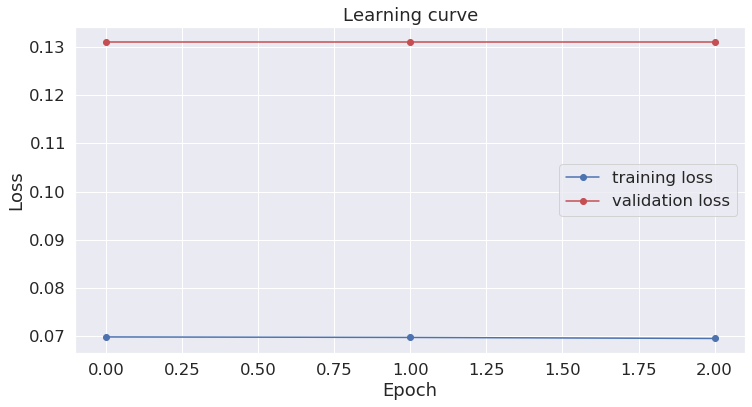

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12, 6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

>  - 模型训练周次太少
 - 模型很快稳定下来

# 使用模型

In [63]:
test_sentence = """
Mr. Trump’s tweets began just moments after a Fox News report by Mike Tobin, a 
reporter for the network, about protests in Minnesota and elsewhere. 
"""

In [65]:
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()
print(input_ids)

tensor([[  101,  1828,   119,  8499,   787,   188,   189, 24887,  1116,  1310,
          1198,  4899,  1170,   170,  3977,  3128,  2592,  1118,  2639,  1706,
          7939,   117,   170,  6672,  1111,  1103,  2443,   117,  1164,  7853,
          1107,  4332,  1105,  6890,   119,   102]], device='cuda:0')


In [66]:
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

In [67]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)

In [68]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))

O	[CLS]
B-per	Mr
B-per	.
I-per	Trump
O	’
O	s
O	tweets
O	began
O	just
O	moments
O	after
O	a
B-org	Fox
I-org	News
O	report
O	by
B-per	Mike
I-per	Tobin
O	,
O	a
O	reporter
O	for
O	the
O	network
O	,
O	about
O	protests
O	in
B-geo	Minnesota
O	and
O	elsewhere
O	.
O	[SEP]
